In [1]:
import sys
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
sys.path.append(SCRIPT_DIR)
import helper
from utils import data_utils
from utils import lmdb_dataset
import matplotlib.pyplot as plt
import torch
from model import models
import json
import os
from model import lightning_models
import math
import torchvision
from torchvision import datasets
import analysis_utils
import numpy as np
from torchvision.transforms import v2
from scipy.optimize import curve_fit


/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
batch_size = 8
model_dir = "../best_imagenet"

In [3]:
config = helper.Config(model_dir,default_config_file="../default_configs/default_config_cifar10.ini")
model = torchvision.models.resnet50(pretrained=False)
model.fc = torch.nn.Identity()
model.load_state_dict(torch.load(os.path.join(model_dir,"ssl","last_epoch_backbone_resnet50.ckpt"),weights_only=True))
device = torch.device("cuda:0")  # Use GPU 0
backbone = model.to(device)

Loading default settings...
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[INFO]
num_nodes = 2
gpus_per_node = 4
cpus_per_gpu = 12
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = ddp
if_profile = False

[DATA]
dataset = IMAGENET1K
n_views = 4
n_trans = 2
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip', 'RandomSolarize']
augmentation_package = albumentations
crop_size = [224, 224]
crop_min_scale = [0.08, 0.08]
crop_max_scale = [1.0, 1.0]
hflip_prob = [0.5, 0.5]
blur_kernel_size = [23, 23]
blur_prob = [1.0, 0.1]
grayscale_prob = [0.2, 0.2]
jitter_brightness = [0.4, 0.4]
jitter_contrast = [0.4, 0.4]
jitter_saturation = [0.2, 0.2]
jitter_hue = [0.1, 0.1]
jitter_prob = [0.8, 0.8]
solarize_prob = [0.0, 0.2]
imagene

/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
val_dir = config.DATA["imagenet_val_dir"]
mean= [0.485, 0.456, 0.406]
std= [0.229, 0.224, 0.225]
if val_dir.endswith("lmdb"):
    img_type = "PIL"
    test_dataset = lmdb_dataset.ImageFolderLMDB(val_dir,img_type=img_type)
else:
    test_dataset = datasets.ImageFolder(root=val_dir)
test_transforms = [v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32,scale=True),
                                v2.Normalize(mean=mean,std=std),
                                v2.Resize(size=256,interpolation=v2.InterpolationMode.BICUBIC),
                                v2.CenterCrop(size=224)])]
test_dataset = data_utils.WrappedDataset(test_dataset,test_transforms,n_views=1,aug_pkg="torchvision")
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 640x480 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

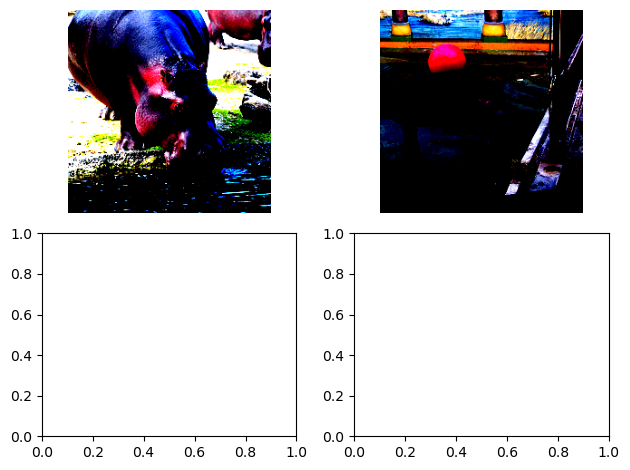

In [5]:
imgs,labels = next(iter(test_loader))
img_list, label_list = [],[]
for i_view in range(1):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)

In [28]:
def sample_representations(backbone,test_dataset,batch_size=8,count=2400):
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 8,pin_memory=True)
    representations = []
    i = 0
    for i,data in enumerate(test_loader):
        imgs,labels = data
        if i > count - 1:
            break
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = backbone(imgs)
            preds = torch.reshape(preds,(1,batch_size,preds.shape[-1])) # n_veiws = 1
            representations.append(torch.squeeze(preds).detach().cpu().numpy())
    reps = np.concatenate(representations) # shape = (count*ouput_dim)
    center = np.mean(reps,axis=0,keepdims=True)
    print(reps.shape)
    print(center.shape)
    reps = reps - center
    #cov = np.einsum("ij,ik->jk",reps,reps) 
    cov = np.matmul(np.transpose(reps),reps)
    print(cov.shape)
    cov /= (reps.shape[0]-1.0)
    return cov

In [36]:
cov = sample_representations(backbone,test_dataset,count=3000)
vals,vecs = np.linalg.eig(cov)
pr = (np.sum(vals)**2) /np.sum(vals*vals)

(24000, 2048)
(1, 2048)
(2048, 2048)


In [37]:
pr

116.40125384246411

In [38]:
sorted_vals = np.sort(vals)[::-1]

In [77]:
rng = [15,1400]
def power_law(x, c, p):
    return c * np.power(x, p)
popt, pcov = curve_fit(power_law, np.arange(rng[0],rng[1]), sorted_vals[rng[0]:rng[1]])
c, p = popt # Extract the fitted parameters

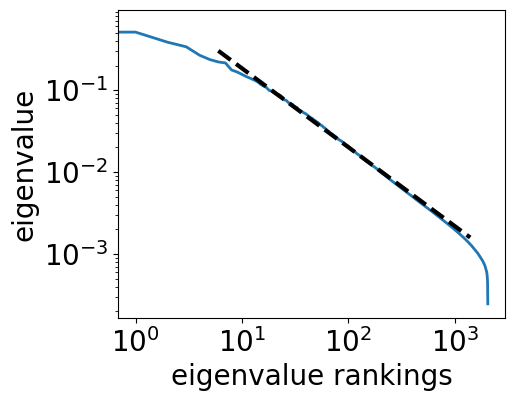

In [79]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax1.loglog(sorted_vals,lw=2)
ax1.loglog(np.arange(int(0.4*rng[0]),rng[1]),c*np.power(np.arange(int(0.4*rng[0]),rng[1]),p),'--',color='black',lw=3)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_xticks([1,10,100,1000])
ax1.set_xlabel("eigenvalue rankings",fontsize=20)
ax1.set_ylabel("eigenvalue",fontsize=20)
plt.savefig("eigen_specturm",bbox_inches='tight',dpi=600)

In [47]:
p

-1.0125926302317287